In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

2024-03-18 14:29:04.349915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:29:04.673574: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 14:29:09.722701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-03-18 14:29:09.724553: W tensorflow/compiler/xla/stre

In [4]:
import json
import sys

In [5]:
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
import matplotlib.pyplot as plt

In [7]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import (
    KoopmanBilinearDLSolver,
    KoopmanLinearDLSolver,
    KoopmanParametricDLSolver,
)
from koopmanlib.target import VanderPolMathieuTarget

In [8]:
config_file = "config_vdpm.json"

index = 0
with open(config_file, "r") as f:
    config = json.load(f)

data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]

n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]
mu = config["data_settings"]["mu"][index]

n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"][index]

In [9]:
dict_layer_size

[64, 64]

In [10]:
print("mu", mu)
print("K_layer_size", K_layer_size)

mu 0
K_layer_size [128]


In [11]:
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

In [12]:
n_psi

13

In [13]:
# Set parameters in the vdpm equation.
k1, k2, k4, w0 = 2, 2, 1, 1

In [14]:
# Load data
dict_data = np.load(
    os.path.join(data_path, "vdpm_data_mu_" + str(mu) + ".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [15]:
vdp_mathieu = VanderPolMathieuTarget(
    mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
)

In [16]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

# Set Linear weights into PKNN
## Design the activation function


In [22]:

@tf.function
def hard_tanh(x):
    return tf.clip_by_value(x, clip_value_min=-1., clip_value_max=1.)

In [23]:
hard_tanh(data_u)

<tf.Tensor: shape=(50000, 1), dtype=float64, numpy=
array([[-0.16595599],
       [ 0.44064899],
       [-0.99977125],
       ...,
       [ 0.52979385],
       [-0.92560571],
       [ 0.7583709 ]])>

In [24]:
data_u

array([[-0.16595599],
       [ 0.44064899],
       [-0.99977125],
       ...,
       [ 0.52979385],
       [-0.92560571],
       [ 0.7583709 ]])

In [25]:
from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation=hard_tanh)

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [189]:
zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

model_pk.compile(optimizer=Adam(0.001), loss="mse")


lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=100,
    verbose=0,
    mode="auto",
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-10,
)

# Define the early stopping criteria
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-12, patience=50, verbose=1, mode="auto"
)

checkpoint_path = os.path.join(weights_path, "hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

from tqdm.keras import TqdmCallback
# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Add early_stopping to the list of callbacks
callbacks = [lr_callback, checkpoint_callback, tqdm_callback]





0epoch [00:24, ?epoch/s]


In [28]:

pknn_epochs = config["nn_settings"]["pknn_epochs"]

history_pk = model_pk.fit(
x=[data_x, data_y, data_u],
y=zeros_data_y_train,
validation_split=0.2,
epochs=pknn_epochs,
batch_size=200,
callbacks=callbacks,
verbose=0,
)


100%|██████████| 500/500 [06:37<00:00,  1.26epoch/s, loss=1.47e-9, val_loss=5.91e-9, lr=1e-7]  


In [26]:
model_pk.load_weights(os.path.join(weights_path, "hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5"))

# DMDc

In [55]:
dic_dmdc = PsiNN(n_psi_train=0, add_constant=False)

In [56]:
solver_dmdc = KoopmanLinearDLSolver(
    dic=dic_dmdc, target_dim=target_dim, param_dim=param_dim, n_psi=target_dim
)
model_dmdc, model_K_u_pred_dmdc = solver_dmdc.build_model()

In [57]:
dic_dmdc.generate_B(data_x)

2


array([[1., 0.],
       [0., 1.]])

# Linear Model: Dynamics is $Az +Bu$

In [27]:
dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [28]:
solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_linear, model_K_u_pred_linear = solver_linear.build_model()

In [29]:
model_linear.load_weights(os.path.join(weights_path, "model_linear_vdpm_mu_" + str(mu) + ".h5"))

## Try to set Linear weights

In [30]:
for i in range(len(model_linear.weights)):
    print('layer size: ', model_linear.weights[i].shape)

layer size:  (2, 64)
layer size:  (64, 64)
layer size:  (64,)
layer size:  (64, 64)
layer size:  (64,)
layer size:  (64, 10)
layer size:  (10,)
layer size:  (13, 13)
layer size:  (1, 13)


In [31]:
K_linear_weights = model_linear.get_layer('K_u_linear_pred').weights

In [32]:
K_linear_weights[1]

<tf.Variable 'Layer_B/kernel:0' shape=(1, 13) dtype=float64, numpy=
array([[-2.56175289e-15,  4.51574192e-05,  1.00591366e-02,
         1.05114961e-03,  4.14935594e-03,  1.53033495e-03,
        -1.06570852e-03,  1.64613125e-03, -1.79409055e-03,
        -1.45446904e-04, -2.10318070e-03,  4.87134872e-04,
         2.11681962e-03]])>

In [42]:
dic_pk_faker = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [43]:
dic_pk_faker(data_x)

<tf.Tensor: shape=(50000, 13), dtype=float64, numpy=
array([[ 1.        ,  0.39293837, -0.42772133, ..., -0.39803476,
        -0.0634612 , -0.19607071],
       [ 1.        , -0.54629709,  0.10262954, ...,  0.2613169 ,
         0.13315093,  0.08076899],
       [ 1.        ,  0.43893794, -0.15378708, ..., -0.25348963,
        -0.10189078, -0.09394875],
       ...,
       [ 1.        , -0.16080765, -1.75050783, ..., -0.86216967,
         0.24666764, -0.58340357],
       [ 1.        ,  0.05699151, -1.33033763, ..., -0.76037075,
         0.13795293, -0.46985893],
       [ 1.        , -0.20198488, -2.0547168 , ..., -0.96177419,
         0.30203558, -0.65153372]])>

In [44]:
dic_pk_faker.set_weights(dic_linear.get_weights())

In [49]:
model_K_u_faker = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation=hard_tanh)

solver_pk_faker = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk_faker, model_K_u=model_K_u_faker
)

model_pk_faker, model_K_u_pred_pk_faker = solver_pk_faker.generate_model()

In [51]:
len(model_pk_faker.get_layer('K_u_pred').weights)

4

In [71]:
hidden_dense_kernel = model_pk_faker.get_layer('K_u_pred').weights[0]

In [72]:
model_pk_faker.get_layer('K_u_pred').weights[0].assign(
    tf.Variable(tf.constant([([1.0] * hidden_dense_kernel.shape[1] if i == 0 else [0.0] * hidden_dense_kernel.shape[1]) for i in range(hidden_dense_kernel.shape[0])], dtype='float64'))
    )

<tf.Variable 'UnreadVariable' shape=(1, 128) dtype=float64, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])>

In [75]:
model_pk_faker.get_layer('K_u_pred').weights[1].assign(
    tf.zeros_like(model_pk_faker.get_layer('K_u_pred').weights[1])
    )

<tf.Variable 'UnreadVariable' shape=(128,) dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])>

In [126]:
trainable_B_from_linear = K_linear_weights[1][:,1:]

In [124]:
zero_B_matrix = np.zeros(model_pk_faker.get_layer('K_u_pred').weights[2].shape, dtype='float64')

In [147]:
for i in range(trainable_B_from_linear.shape[-1]):
    zero_B_matrix[i,i] = trainable_B_from_linear[0,i]

In [148]:
set_output_layer_kernel_weights = tf.Variable(zero_B_matrix)

In [149]:
set_output_layer_bias_weights = tf.reshape(K_linear_weights[0][:,1:], shape=model_pk_faker.get_layer('K_u_pred').weights[3].shape)

In [150]:
model_pk_faker.get_layer('K_u_pred').weights[2].assign(
    set_output_layer_kernel_weights
    )

<tf.Variable 'UnreadVariable' shape=(128, 156) dtype=float64, numpy=
array([[4.51574192e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00591366e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.05114961e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])>

In [151]:
model_pk_faker.get_layer('K_u_pred').weights[3].assign(
    set_output_layer_bias_weights
    )

<tf.Variable 'UnreadVariable' shape=(156,) dtype=float64, numpy=
array([ 3.94845674e-05,  8.83166490e-03,  5.47554181e-03, -7.59532262e-03,
        2.46115773e-03,  7.83433572e-03,  8.80262722e-03, -7.51704222e-03,
       -5.67505755e-03, -1.74687247e-03,  1.56132159e-02, -6.59015747e-03,
        1.00076182e+00,  1.64890787e-01, -1.70957936e-02,  9.95357065e-02,
        6.67900079e-02, -1.16890575e-02,  3.26710991e-03, -3.45848265e-02,
       -3.90870076e-02, -6.52488721e-03, -3.49217570e-02,  4.53576238e-02,
        1.70822454e-02,  2.58764381e+00,  2.94701781e-01,  3.86317977e-01,
        1.95449750e-01,  3.44148848e-02,  4.04374561e-01, -4.15705962e-01,
       -6.15446124e-02, -3.83932386e-01,  4.28636474e-01,  1.45889252e-01,
       -2.91381707e-03, -6.59368608e-01,  7.29042180e-01,  1.98208311e-01,
       -8.48748538e-02, -2.42476507e-01, -4.18119602e-01,  3.60526782e-01,
        1.62695891e-01,  1.62142466e-01, -6.66483237e-01,  1.29357348e-01,
       -3.13395831e-03, -7.02352240

## Continue to train from linear weights


In [190]:
model_pk_faker.compile(optimizer=Adam(1e-5), loss="mse")
    
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=100,
    verbose=0,
    mode="auto",
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-10,
)

# Define the early stopping criteria
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-12, patience=50, verbose=1, mode="auto"
)

checkpoint_path = os.path.join(weights_path, "train_from_linear_hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

from tqdm.keras import TqdmCallback

# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Add early_stopping to the list of callbacks
callbacks = [lr_callback, checkpoint_callback, tqdm_callback]


0epoch [00:10, ?epoch/s]




In [191]:
history_pk_faker = model_pk_faker.fit(
x=[data_x, data_y, data_u],
y=zeros_data_y_train,
validation_split=0.2,
epochs=200,
batch_size=200,
callbacks=callbacks,
verbose=0,
)

100%|██████████| 200/200 [03:01<00:00,  1.10epoch/s, loss=1.43e-9, val_loss=6.9e-9, lr=1e-6] 


In [192]:
model_pk_faker.load_weights(os.path.join(weights_path, "train_from_linear_hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5"))

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

In [193]:
dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [194]:
solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()

In [195]:
model_bilinear.load_weights(
    os.path.join(weights_path, "model_bilinear_vdpm_mu_" + str(mu) + ".h5")
)

In [196]:
model_K_u_pred_bilinear.summary()

Model: "K_u_bilinear_pred"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 13)]         0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.einsum_1 (TFOpLambda)       (1, None, 13)        0           ['input_32[0][0]',               
                                                                  'input_31[0][0]']               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 13)          0           ['tf.einsum_1[0][

In [197]:


# # Train K(u) to be (A+Bu)
# psi_x_data = dic_bilinear(data_x)
# target = model_K_u_pred_bilinear([data_u, psi_x_data])
# inputs_u = Input(shape=(param_dim,))
# inputs_psi_x = Input(shape=(n_psi,))

# fake_psi = model_K_u_pred_pk([inputs_u, inputs_psi_x])

# test_K_model = Model(inputs=[inputs_u, inputs_psi_x], outputs=fake_psi)

# test_K_model.compile(optimizer=Adam(0.000001), loss="mse")
# test_K_model.fit(x=[data_u, psi_x_data], y=target, epochs=500, batch_size=200, verbose=1)
# dic_pk.set_weights(dic_bilinear.get_weights())



## Prediction

In [198]:
from koopmanlib.functions import *

## Calculate average value

In [199]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1, 300, size=(n_test,))
seed_param_list = np.random.randint(1, 300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [200]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []
# ratio_dmdc_list = []
ratio_pk_faker_list = []

In [201]:
data_pred_list_pk_group = []
data_pred_list_linear_group = []
data_pred_list_bilinear_group = []
data_true_group = []
# data_pred_list_dmdc_group = []
data_pred_list_pk_faker_group = []


In [202]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(
        mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
    )

    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(
        n_traj=n_traj_test, traj_len=traj_len_test, seed_x=seed_x, seed_param=seed_param
    )
    data_x_init = tf.reshape(data_x_test[0], shape=(1, -1))
    data_true = data_x_test

    data_pred_list_pk = solver_pk.compute_data_list(traj_len_test, data_x_init, data_u_test)
    data_pred_list_pk_faker = solver_pk_faker.compute_data_list(traj_len_test, data_x_init, data_u_test)
    data_pred_list_linear = solver_linear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )
    data_pred_list_bilinear = solver_bilinear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )

    # data_pred_list_dmdc = solver_dmdc.compute_data_list(
    #     traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    # )

    ratio_pk = compute_diff_ratio_one_traj(data_true, data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, data_pred_list_bilinear)
    # ratio_dmdc = compute_diff_ratio_one_traj(data_true, data_pred_list_dmdc)
    ratio_pk_faker = compute_diff_ratio_one_traj(data_true, data_pred_list_pk_faker)

    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)
    # ratio_dmdc_list.append(ratio_dmdc)
    ratio_pk_faker_list.append(ratio_pk_faker)

    data_pred_list_pk_group.append(data_pred_list_pk)
    data_pred_list_linear_group.append(data_pred_list_linear)
    data_pred_list_bilinear_group.append(data_pred_list_bilinear)
    # data_pred_list_dmdc_group.append(data_pred_list_dmdc)
    data_pred_list_pk_faker_group.append(data_pred_list_pk_faker)

    data_true_group.append(data_true)

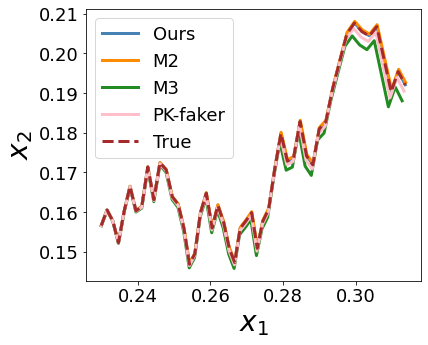

In [203]:
plt.figure(figsize=(6, 5))

plt.plot(
    data_pred_list_pk[:, 0], 
    data_pred_list_pk[:, 1], 
    label="Ours", 
    color="steelblue", 
    linewidth=3
)
    
plt.plot(
    data_pred_list_linear[:, 0],
    data_pred_list_linear[:, 1],
    label="M2",
    color="darkorange",
    linewidth=3,
)
plt.plot(
    data_pred_list_bilinear[:, 0],
    data_pred_list_bilinear[:, 1],
    label="M3",
    color="forestgreen",
    linewidth=3,
)

# plt.plot(
# data_pred_list_dmdc[:,0],
# data_pred_list_dmdc[:,1],
# label='DMDc',
# color='red',
# linewidth=3
# )

plt.plot(
    data_pred_list_pk_faker[:, 0], 
    data_pred_list_pk_faker[:, 1], 
    label="PK-faker", 
    color="pink", 
    linewidth=3
)


plt.plot(
    data_true[:, 0], data_true[:, 1], label="True", color="brown", linestyle="dashed", linewidth=3
)
plt.xlabel(r"$x_{1}$", fontsize=28)
plt.ylabel(r"$x_{2}$", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [204]:
data_pred_list_pk_group = np.asarray(data_pred_list_pk_group)
data_pred_list_linear_group = np.asarray(data_pred_list_linear_group)
data_pred_list_bilinear_group = np.asarray(data_pred_list_bilinear_group)
# data_pred_list_dmdc_group = np.asarray(data_pred_list_dmdc_group)
data_pred_list_pk_faker_group = np.asarray(data_pred_list_pk_faker_group)
data_true_group = np.asarray(data_true_group)

In [205]:
# for i in range(data_pred_list_pk_group.shape[0]):
#     plt.figure(figsize=(6, 5))
#     plt.plot(
#         data_pred_list_pk_group[i, :, 0],
#         data_pred_list_pk_group[i, :, 1],
#         label="Ours",
#         color="steelblue",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_linear_group[i, :, 0],
#         data_pred_list_linear_group[i, :, 1],
#         label="M2",
#         color="darkorange",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_bilinear_group[i, :, 0],
#         data_pred_list_bilinear_group[i, :, 1],
#         label="M3",
#         color="forestgreen",
#         linewidth=3,
#     )
#     plt.plot(
#         data_true_group[i, :, 0],
#         data_true_group[i, :, 1],
#         label="True",
#         color="brown",
#         linestyle="dashed",
#         linewidth=3,
#     )
#     plt.xlabel(r"$x_{1}$", fontsize=28)
#     plt.ylabel(r"$x_{2}$", fontsize=28)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.legend(fontsize=18)

In [206]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_linear_list = np.asarray(ratio_linear_list)
ratio_bilinear_list = np.asarray(ratio_bilinear_list)
# ratio_dmdc_list = np.asarray(ratio_dmdc_list)
ratio_pk_faker_list = np.asarray(ratio_pk_faker_list)

In [207]:
ratio_pk_list_mean = np.mean(ratio_pk_list, axis=0)
ratio_linear_list_mean = np.mean(ratio_linear_list, axis=0)
ratio_bilinear_list_mean = np.mean(ratio_bilinear_list, axis=0)
# ratio_dmdc_list_mean = np.mean(ratio_dmdc_list, axis=0)
ratio_pk_faker_list_mean = np.mean(ratio_pk_faker_list, axis=0)

In [208]:
ratio_pk_list_median = np.median(ratio_pk_list, axis=0)
ratio_linear_list_median = np.median(ratio_linear_list, axis=0)
ratio_bilinear_list_median = np.median(ratio_bilinear_list, axis=0)
# ratio_dmdc_list_median = np.median(ratio_dmdc_list, axis=0)
ratio_pk_faker_list_median = np.median(ratio_pk_faker_list, axis=0)

In [209]:
q_min = 0.35
q_max = 0.65

In [210]:
ratio_pk_list

array([[0.00000000e+00, 7.90979852e-05, 1.42658789e-04, 2.06403425e-04,
        2.70658871e-04, 3.36643736e-04, 4.05799418e-04, 4.78037493e-04,
        5.52101399e-04, 6.26781661e-04, 7.01245424e-04, 7.76060613e-04,
        8.50391197e-04, 9.25555666e-04, 1.00027286e-03, 1.07442094e-03,
        1.14833662e-03, 1.22232341e-03, 1.29676856e-03, 1.36940319e-03,
        1.44135486e-03, 1.51312841e-03, 1.58362438e-03, 1.65266983e-03,
        1.72037574e-03, 1.78675501e-03, 1.85016168e-03, 1.91183373e-03,
        1.97102069e-03, 2.02783262e-03, 2.08129552e-03, 2.13064999e-03,
        2.17568477e-03, 2.21603217e-03, 2.25230054e-03, 2.28407926e-03,
        2.31215851e-03, 2.33579331e-03, 2.35467156e-03, 2.36862686e-03,
        2.37844450e-03, 2.38413807e-03, 2.38527017e-03, 2.38248562e-03,
        2.37619443e-03, 2.36662323e-03, 2.35409718e-03, 2.33848235e-03,
        2.32010821e-03, 2.29988908e-03],
       [0.00000000e+00, 5.88026994e-05, 1.09452331e-04, 1.59452756e-04,
        2.10341978e-04,

In [211]:
ratio_pk_list_min = np.quantile(ratio_pk_list, q=q_min, axis=0)
ratio_linear_list_min = np.quantile(ratio_linear_list, q=q_min, axis=0)
ratio_bilinear_list_min = np.quantile(ratio_bilinear_list, q=q_min, axis=0)
# ratio_dmdc_list_min = np.quantile(ratio_dmdc_list, q=q_min, axis=0)
ratio_pk_faker_list_min = np.quantile(ratio_pk_faker_list, q=q_min, axis=0)

In [212]:
ratio_pk_list_max = np.quantile(ratio_pk_list, q=q_max, axis=0)
ratio_linear_list_max = np.quantile(ratio_linear_list, q=q_max, axis=0)
ratio_bilinear_list_max = np.quantile(ratio_bilinear_list, q=q_max, axis=0)
# ratio_dmdc_list_max = np.quantile(ratio_dmdc_list, q=q_max, axis=0)
ratio_pk_faker_list_max = np.quantile(ratio_pk_faker_list, q=q_max, axis=0)

In [213]:
x_axis = np.arange(0, traj_len_test, 1)

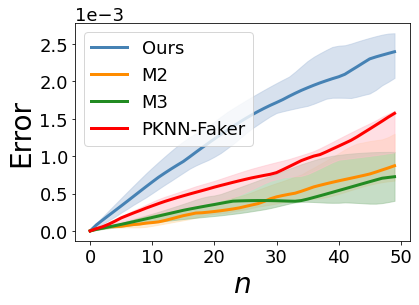

In [214]:
plt.figure(figsize=(6, 4))

plt.plot(ratio_pk_list_median, label="Ours", color="steelblue", linewidth=3)
plt.fill_between(x_axis, ratio_pk_list_min, ratio_pk_list_max, color="lightsteelblue", alpha=0.5)
plt.plot(ratio_linear_list_median, label="M2", color="darkorange", linewidth=3)
plt.fill_between(
    x_axis, ratio_linear_list_min, ratio_linear_list_max, color="navajowhite", alpha=0.5
)
plt.plot(ratio_bilinear_list_median, label="M3", color="forestgreen", linewidth=3)
plt.fill_between(
    x_axis, ratio_bilinear_list_min, ratio_bilinear_list_max, color="darkseagreen", alpha=0.5
)

plt.plot(ratio_pk_faker_list_median, label="PKNN-Faker", color="red", linewidth=3)
plt.fill_between(x_axis, ratio_pk_faker_list_min, ratio_pk_faker_list_max, color="pink", alpha=0.5)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [177]:
dict_mean = {
    "pk": ratio_pk_list_mean,
    "linear": ratio_linear_list_mean,
    "bilinear": ratio_bilinear_list_mean,
}

In [ ]:
# np.save(os.path.join(data_path, "ratio_list_dict_mu_" + str(mu) + "_mean.npy"), dict_mean)

# See the comparison
If you have tested on all $\mu: 0,1,2,3,4$, then you can run the following codes to see the comparison.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean_dict_mu_0 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_0_mean.npy"), allow_pickle=True
)
mean_dict_mu_1 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_1_mean.npy"), allow_pickle=True
)
mean_dict_mu_2 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_2_mean.npy"), allow_pickle=True
)
mean_dict_mu_3 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_3_mean.npy"), allow_pickle=True
)
mean_dict_mu_4 = np.load(
    os.path.join(data_path, "ratio_list_dict_mu_4_mean.npy"), allow_pickle=True
)


def extact_data(ratio_dict, ratio_name):
    ratio_pk = ratio_dict[()][ratio_name[0]].reshape((1, -1))
    ratio_linear = ratio_dict[()][ratio_name[1]].reshape((1, -1))
    ratio_bilinear = ratio_dict[()][ratio_name[2]].reshape((1, -1))
    return ratio_pk, ratio_linear, ratio_bilinear


mean_dict_list = [mean_dict_mu_0, mean_dict_mu_1, mean_dict_mu_2, mean_dict_mu_3, mean_dict_mu_4]

ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

ratio_name_list = ["pk", "linear", "bilinear"]


def concat_ratio_list(ratio_list):
    ratio_concat = np.concatenate(ratio_list, axis=0)
    ratio_concat = ratio_concat.T
    return ratio_concat


def concat_data(dict_list):
    pk_list = []
    linear_list = []
    bilinear_list = []

    for i in range(5):
        pk, linear, bilinear = extact_data(dict_list[i], ratio_name=ratio_name_list)
        pk_list.append(pk)
        linear_list.append(linear)
        bilinear_list.append(bilinear)

    pk_concat = concat_ratio_list(pk_list)
    linear_concat = concat_ratio_list(linear_list)
    bilinear_concat = concat_ratio_list(bilinear_list)

    return pk_concat, linear_concat, bilinear_concat


mean_pk, mean_linear, mean_bilinear = concat_data(mean_dict_list)

mean_linear_mean = np.mean(mean_linear, axis=0)
mean_bilinear_mean = np.mean(mean_bilinear, axis=0)
mean_pk_mean = np.mean(mean_pk, axis=0)

mu = [0, 1, 2, 3, 4]
mu_axis = list(range(len(mu)))


def plot_evaluate_vdpm(mu, mean, dict_plot):
    plt.plot(
        mu,
        mean,
        label=dict_plot["label"],
        marker=dict_plot["marker"],
        markersize=dict_plot["markersize"],
        color=dict_plot["color"],
        linestyle=dict_plot["linestyle"],
        linewidth=dict_plot["linewidth"],
    )


label_font = 24
ticks_font = 18
legend_font = 22


dict_plot_pk = {
    "label": "Ours",
    "marker": "*",
    "markersize": 10,
    "color": "steelblue",
    "linestyle": "-",
    "linewidth": 3,
}

dict_plot_linear = {
    "label": "M2",
    "marker": "s",
    "markersize": 10,
    "color": "darkorange",
    "linestyle": "-",
    "linewidth": 3,
}

dict_plot_bilinear = {
    "label": "M3",
    "marker": "o",
    "markersize": 10,
    "color": "forestgreen",
    "linestyle": "-",
    "linewidth": 3,
}

plt.figure(figsize=(15, 4))
plot_evaluate_vdpm(mu, mean_pk_mean, dict_plot=dict_plot_pk)
plot_evaluate_vdpm(mu, mean_linear_mean, dict_plot=dict_plot_linear)

plot_evaluate_vdpm(mu, mean_bilinear_mean, dict_plot=dict_plot_bilinear)

plt.xlabel(r"$\mu$", loc="right", fontsize=label_font)
plt.ylabel("Error", fontsize=label_font)
plt.xticks(mu_axis, mu, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.legend(fontsize=legend_font)